In [1]:
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

# system ----
import os
import sys
import csv
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import display, HTML

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

# local ----
localPath = os.path.expanduser("~/")
projPath = os.path.expanduser(localPath+"_projects/researchproject_007/")
sys.path.append(projPath+"modules")
import plot_parameters 

In [22]:
class NFW(object): 
    def density(self, r: float, rhos: float, rs: float) -> float:
        """Density profile"""
        x = r/rs
        term1 = x * np.power(1+x,2)
        return np.float64(rhos)/term1

    def normalization(self, mvir: float, rvir: float, c: float) -> float:
        """
        """
        results = dict()
        f = np.log(1.0 + c) - c/(1.0 + c)
        results['norm'] = mvir * c**3 /(4.*np.pi * rvir**3 * f)
        results['rs'] = rvir / c
        return results

    def surface_density(self, r: float, rhos: float, rs: float) -> float:
        """
        """
        x = r/rs
        if isinstance(r, float):
            if(x > 1.0):
                factor = 1.0 / (x**2 - 1.0)
                F = factor * (1.0 - 2.0/np.sqrt(x**2 - 1.0) * np.arctan(np.sqrt(x - 1.0)/np.sqrt(1.0 + x)))
            elif(x == 1.0):
                F = 1.0 / 3.0
            elif(x < 1.0):
                factor = 1.0 / (x**2 - 1.0)
                F = factor * (1.0 - 2.0/np.sqrt(1.0 - x**2) * np.arctanh(np.sqrt(1.0 - x)/np.sqrt(1.0 + x)))
        else:
            F = np.zeros(r.shape[0])
            for i in range(r.shape[0]):
                xx = x[i]
                if(xx > 1.0):
                    factor = 1.0 / (xx**2 - 1.0)
                    F = factor * (1.0 - 2.0/np.sqrt(xx**2 - 1.0) * np.arctan(np.sqrt(xx - 1.0)/np.sqrt(1.0 + xx)))
                elif(xx == 1.0):
                    F = 1.0 / 3.0
                elif(xx < 1.0):
                    factor = 1.0 / (xx**2 - 1.0)
                    F = factor * (1.0 - 2.0/np.sqrt(1.0 - xx**2) * np.arctanh(np.sqrt(1.0 - xx)/np.sqrt(1.0 + xx)))
        return (2.0 * rhos * rs) * F

    def surface_mass(self, R: float, rhos: float, rs: float) -> float:
        """The enclosed projected mass at radius R (kpc) """
        integrand = lambda r: r * self.surface_density(r, rhos, rs)
        if isinstance(R, float):
            result = 2.0 * np.pi * quad(integrand, 0.0, R)[0]
        else:
            result = np.zeros(R.shape[0])
            for i in range(R.shape[0]):
                result[i] += 2.0 * np.pi * quad(integrand, 0.0, R[i])[0]
        return result 

In [23]:
class Lazar(object):
    def surface_density(self, R: float, E1: float, R1: float):
        beta = 0.3
        B = -1.0/beta * (np.power(R/R1,beta) - 1.0)
        return E1 * np.exp(B)

    def surface_mass(self, R: float, E1: float, R1: float):
        """"""
        integrand = lambda r: r * self.surface_density(r, E1, R1)
        if isinstance(R, float):
            result = 2.0 * np.pi * quad(integrand, 0.0, R)[0]
        else:
            result = np.zeros(R.shape[0])
            for i in range(R.shape[0]):
                result[i] += 2.0 * np.pi * quad(integrand, 0.0, R[i])[0]
        return result 

    def norm_integration_fit(self, C: float):
        c0, c1, c2 = 5756, 0.628, 0.438
        n  = 7.41
        A = -n * np.power((C + c1)/c2, 1.0/n)
        return c0 * np.exp(A)
    
    def meff_power_law(self, mdelta: float, a: float, b: float):
        """Returns median projected mass given `mdelta` [Msol/h]"""
        return 10.0**a * np.power(mdelta/1e10, b) # Msol/h

    def normalization(self, c: float, rdelta: float, mdelta: float) -> float:
        """Returns normalization given enclosed mass `mdelta` [Msol] and 'rdelta' [physical kpc]"""
        #meff = self.meff_power_law(mdelta=mdelta*h, a=9.52, b=0.94) / h
        meff = mdelta 
        result = meff / (2.0 * np.pi) / rdelta**2 / self.norm_integration_fit(C=c)
        return result # Msol/kpc^3

In [24]:
# 3.405 kpc/" for z=0.2 in PLANCK15
# 6.288 kpc/" for z=0.5 in PLANCK15

from scipy.integrate import quad
from scipy.interpolate import interp1d
from colossus.cosmology import cosmology
from colossus.halo import concentration
from colossus.halo import profile_nfw
from colossus.halo import mass_so

cosmo = cosmology.setCosmology('planck15');
h = cosmo.H0 / 100.0

class BaseAnalysis(object):
    def __init__(self, n_realizations: int = 500, r_limit: float = 0.1):
        self.N = n_realizations
        self.rlim = r_limit
        
    def nfw_model_list(self) -> str:
        return ['ishiyama21', 'diemer19', 'dutton14', 'bullock01']
        
    def sample_nfw_concentration(self, mass: float, model: str='diemer19') -> float:
        """ """
        median_concentration = concentration.concentration(mass*h, 'vir', z=0.2, model=model)
        random_concentration = np.random.lognormal(np.log(median_concentration), 0.12)
        return random_concentration
        
    def integrate_nfw_mass(self, mass: float, c_rnd: float) -> float:
        """ """
        results = dict()
        
        results['m.vir'] = mass
        results['c.vir'] = c_rnd

        nfw = profile_nfw.NFWProfile(M=mass*h, c=c_rnd, z=0.2, mdef='vir')
        results['E'] = nfw.surfaceDensity(self.rlim*h)
        
        integrand = lambda r: r * nfw.surfaceDensity(r*h)
        results['M.enc']  = 2.0 * np.pi * quad(integrand, 0.0, self.rlim)[0]
        return results
    
    def integrate_nfw_mass2(self, mass: float, c_rnd: float) -> float:
        """ """
        results = dict()
        
        results['m.vir'] = mass
        results['c.vir'] = c_rnd

        model = NFW()
        rvir = mass_so.M_to_R(mass*h, 0.2, 'vir') / h # physical kpc
        norm = model.normalization(mvir=mass, rvir=rvir, c=c_rnd)
        rhos = norm['norm']
        rs = norm['rs']
                                           
        results['E'] = model.surface_density(r=self.rlim, rhos=rhos, rs=rs)
        results['M.enc']  = model.surface_mass(R=self.rlim, rhos=rhos, rs=rs)
        return results
    
    def sample_nfw(self, log_mbounds: float):
        """ """
        results = dict()
        
        random_powers = np.random.uniform(low=log_mbounds[0],
                                          high=log_mbounds[1],
                                          size=self.N)
        random_maasses = 10.0**random_powers
        n_models = len(self.nfw_model_list())
        n_total = n_models * self.N
        mass_arr = [] * n_total
        conc_arr = [] * n_total
        menc_arr = [] * n_total
        sden_arr = [] * n_total
        
        for ind, mass in enumerate(random_maasses):
            for model in self.nfw_model_list():
                crnd = self.sample_nfw_concentration(mass=mass, model=model)
                res = self.integrate_nfw_mass2(mass=mass, c_rnd=crnd)
                mass_arr.append(res['m.vir'])
                conc_arr.append(res['c.vir'])
                menc_arr.append(res['M.enc'])
                sden_arr.append(res['E'])
        results['m.vir'] = np.array(mass_arr)
        results['c.vir'] = np.array(conc_arr)
        results['M.enc'] = np.array(menc_arr)
        results['E'] = np.array(sden_arr)
        return results
    
    def sample_proj_concentration(self, mvir: float) -> float:
        """ """
        txt02 = np.loadtxt("effConc_DJ19_z02.txt")
        x02, y02 = txt02[:, 0], txt02[:, 1]
        intp02 = interp1d(x02, y02, fill_value="extrapolate")
        median_concentration = intp02(mvir*h)
        random_concentration = np.random.lognormal(np.log(median_concentration), 0.11)
        return random_concentration
    
    def integrate_lazar_mass(self, mass: float, c_rnd: float) -> float:
        """ """
        results = dict()
        
        results['m.vir'] = mass
        results['c.vir'] = c_rnd
        
        model = Lazar()
        rvir = mass_so.M_to_R(mass*h, 0.2, 'vir') / h # physical kpc
        norm = model.normalization(c=c_rnd, rdelta=rvir, mdelta=mass)
        R1 = rvir / c_rnd
        
        results['E'] = model.surface_density(R=self.rlim, E1=norm, R1=R1)
        
        results['M.enc'] = model.surface_mass(R=self.rlim, E1=norm, R1=R1)
        
        return results
    
    def sample_lazar(self, log_mbounds: float):
        """ """
        results = dict()
        
        random_powers = np.random.uniform(low=log_mbounds[0],
                                          high=log_mbounds[1],
                                          size=self.N)
        random_masses = 10.0**random_powers
        n_total = self.N
        mass_arr = [] * n_total
        conc_arr = [] * n_total
        menc_arr = [] * n_total
        sden_arr = [] * n_total
        
        for ind, mass in enumerate(random_masses):
            for model in self.nfw_model_list():
                crnd = self.sample_proj_concentration(mvir=mass)
                res = self.integrate_lazar_mass(mass=mass, c_rnd=crnd)
                mass_arr.append(res['m.vir'])
                conc_arr.append(res['c.vir'])
                menc_arr.append(res['M.enc'])
                sden_arr.append(res['E'])
        results['m.vir'] = np.array(mass_arr)
        results['c.vir'] = np.array(conc_arr)
        results['M.enc'] = np.array(menc_arr)
        results['E'] = np.array(sden_arr)
        return results
    
    def get_statistics(self, xdata: float, ydata: float, nbins: int = 25, 
                             clean_up: bool = True, xbound: float = None,
                             *args, **kwargs) -> float:
        """ """
        results = dict()
        
        if xbound == None:    
            power_arr = np.linspace(np.log10(xdata.min()), np.log10(xdata.max()), nbins)
        elif isinstance(xbound, tuple):
            power_arr = np.linspace(np.log10(xbound[0]), np.log10(xbound[1]), nbins)         
        x_arr = 10 ** power_arr
        delta = x_arr[1] - x_arr[0]
        idx = np.digitize(xdata, x_arr)
        
        results['x.bins'] = x_arr - delta/2.0
        results['y.median'], results['y.average'] = np.zeros(nbins), np.zeros(nbins)
        results['y.1sigma.upper'], results['y.1sigma.lower'] = np.zeros(nbins), np.zeros(nbins)
        results['y.2sigma.upper'], results['y.2sigma.lower'] = np.zeros(nbins), np.zeros(nbins)
        results['y.3sigma.upper'], results['y.3sigma.lower'] = np.zeros(nbins), np.zeros(nbins)

        for ind, x in enumerate(x_arr):
            yi = ydata[idx == ind]
            percentage = [0.68, 0.90, 0.99]
            try:
                yis = np.sort(yi)
                results['y.median'][ind] += yis[int(0.50*yi.shape[0])]
                results['y.average'][ind] += np.average(yi)
                for ip, numb in enumerate(percentage):
                    results[f'y.{ip+1}sigma.upper'][ind] = yis[round(numb*yi.shape[0])]
                    results[f'y.{ip+1}sigma.lower'][ind] = yis[round((1.0-numb)*yi.shape[0])]
            except IndexError:
                pass
            
        if clean_up:
            cond1 = results['y.median'] != 0
            cond2 = results['x.bins'] >= xdata.min()
            w = np.where(cond1 & cond2)[0]
            for skey, sval in results.items():
                results[skey] = sval[w]
        
        return results

In [31]:
"""
"""
ba = BaseAnalysis(n_realizations=3000, r_limit=0.1)

res_nfw = ba.sample_nfw(log_mbounds=(5.5, 10.5))
np.savetxt('nfw_res.txt', np.c_[res_nfw['m.vir'], res_nfw['E'], res_nfw['M.enc']], fmt="%s %s %s")

res_laz = ba.sample_lazar(log_mbounds=(5.5, 10.5))
np.savetxt('laz_res.txt', np.c_[res_laz['m.vir'], res_laz['E'], res_laz['M.enc']], fmt="%s %s %s")
"""
"""

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/colossus/halo/concentration.py:441: UserWarning: Some masses or redshifts are outside the validity of the concentration model.
  warnings.warn('Some masses or redshifts are outside the validity of the concentration model.')


'\n'

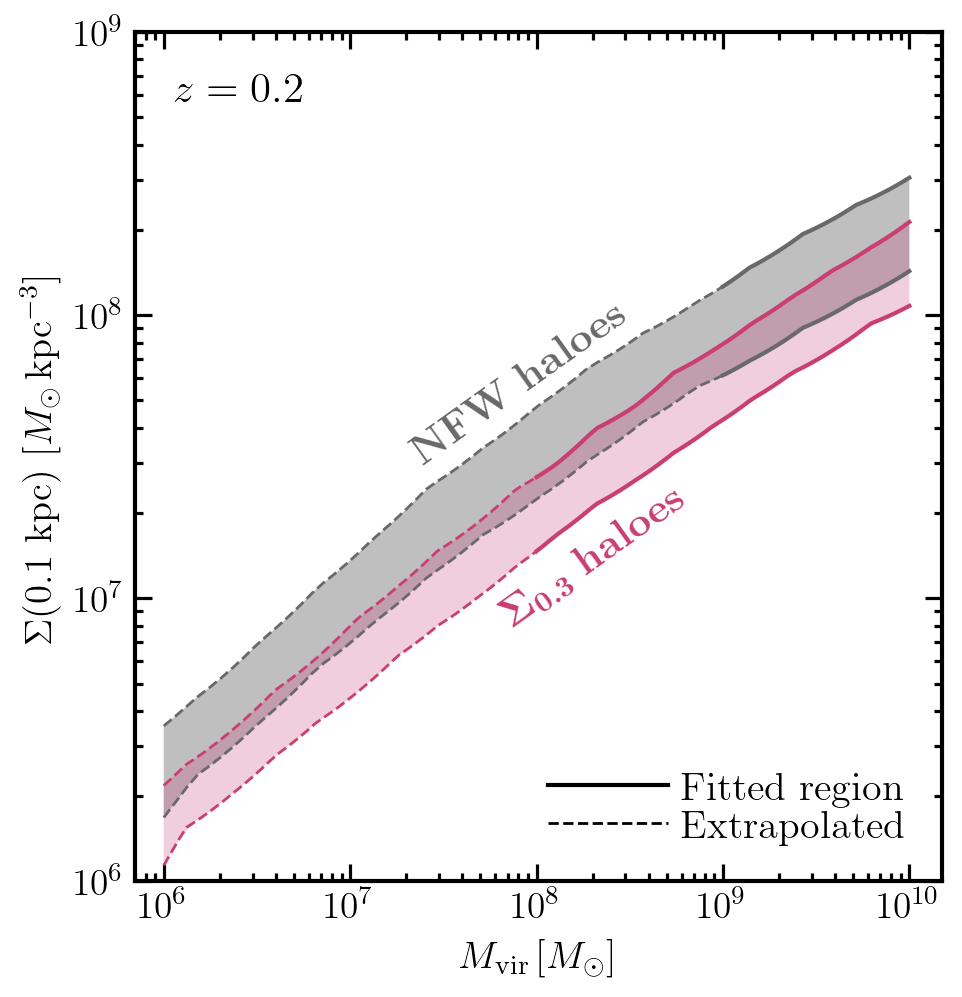

In [48]:
fig,axs=plt.subplots(figsize=(6.25/1.2,6.75/1.2),
                     nrows=1,ncols=1,
                    dpi=100)
plt.subplots_adjust(wspace=0.05, hspace=0.015)

# -----------------------------------------------------------------------------------------

axs.xaxis.set_tick_params(direction='in', which='both'); axs.yaxis.set_tick_params(direction='in', which='both')
axs.xaxis.set_ticks_position('both'); axs.yaxis.set_ticks_position('both')
axs.set_xlabel(r'$M_{\rm vir}\, [M_{\odot}]$'); axs.set_ylabel(r'$\Sigma(0.1\ \mathrm{kpc})\ [M_{\odot}\, \rm kpc^{-3}]$')
axs.set_xscale('log'); axs.set_yscale('log');
axs.set_xlim(7e5, 1.5e10); axs.set_ylim(1e6, 1e9)

# -----------------------------------------------------------------------------------------

axs.text(2e7, 3e7, r'\boldmath$\rm NFW\ haloes$', color='dimgray', rotation=35.5)
res = np.loadtxt('nfw_res.txt', delimiter=' ', dtype=np.float64)
#axs.scatter(res[:, 0], res[:, 1], s=2.5, c='dimgray')

stats_nfw = ba.get_statistics(xdata=res[:, 0], 
                              ydata=res[:, 1], 
                              nbins=15,
                              xbound=(1e6, 1e10),
                              clean_up=True)

marr = 10**np.linspace(6, 10)
marr1 = 10**np.linspace(9, 10)
marr2 = 10**np.linspace(6, 9)
intp1 = interp1d(stats_nfw['x.bins'], stats_nfw['y.3sigma.lower'], fill_value='extrapolate')
intp2 = interp1d(stats_nfw['x.bins'], stats_nfw['y.3sigma.upper'], fill_value='extrapolate')
axs.fill_between(marr, 
                 intp1(marr), 
                 intp2(marr), 
                 edgecolor='None', facecolor='k', alpha=0.25)
axs.plot(marr1, intp1(marr1), lw=1.5, color='dimgray')
axs.plot(marr1, intp2(marr1), lw=1.5, color='dimgray')
axs.plot(marr2, intp1(marr2), lw=1.0, color='dimgray', ls='--')
axs.plot(marr2, intp2(marr2), lw=1.0, color='dimgray', ls='--')

# -----------------------------------------------------------------------------------------

cmap = matplotlib.cm.get_cmap('magma')
color=cmap(0.55)

axs.text(6e7, 8e6, r'\boldmath$\rm \Sigma_{0.3}\ haloes$', color=color, rotation=35.5)
res = np.loadtxt('laz_res.txt', delimiter=' ', dtype=np.float64)
#axs.scatter(res[:, 0], res[:, 1], s=2.5, c=color)

stats_laz = ba.get_statistics(xdata=res[:, 0], 
                              ydata=res[:, 1], 
                              nbins=20,
                              xbound=(1e6, 1e10),
                              clean_up=True)

marr = 10**np.linspace(6, 10)
marr1 = 10**np.linspace(8, 10)
marr2 = 10**np.linspace(6, 8)
intp1 = interp1d(stats_laz['x.bins'], stats_laz['y.3sigma.lower'], fill_value='extrapolate')
intp2 = interp1d(stats_laz['x.bins'], stats_laz['y.3sigma.upper'], fill_value='extrapolate')
axs.fill_between(marr, 
                 intp1(marr), 
                 intp2(marr), 
                 edgecolor='None', facecolor=color, alpha=0.25)
axs.plot(marr1, intp1(marr1), lw=1.5, color=color)
axs.plot(marr1, intp2(marr1), lw=1.5, color=color)
axs.plot(marr2, intp1(marr2), lw=1.0, color=color, ls='--')
axs.plot(marr2, intp2(marr2), lw=1.0, color=color, ls='--')

# -----------------------------------------------------------------------------------------

from matplotlib.patches import Rectangle
empty = Rectangle((0,0), 0, 0, alpha=0.0)

sim_leg = axs.legend([empty]*7,
                [r'$z = 0.2$'],
               loc="upper left",frameon=False,ncol=1,
               fontsize=15.5,handlelength=0,handletextpad=0,labelspacing=0.05)
sim_leg.get_texts()[0].set_color('k')
axs.add_artist(sim_leg)

axs.plot(1, 1, lw=1.5, ls='-', color='k', label=r'$\rm Fitted\ region$')
axs.plot(1, 1, lw=1.0, ls='--', color='k', label=r'$\rm Extrapolated$')
axs.legend(frameon=False, loc='lower right', fontsize=14.5, handlelength=3, handletextpad=0.3, labelspacing=0.05)


plt.show()

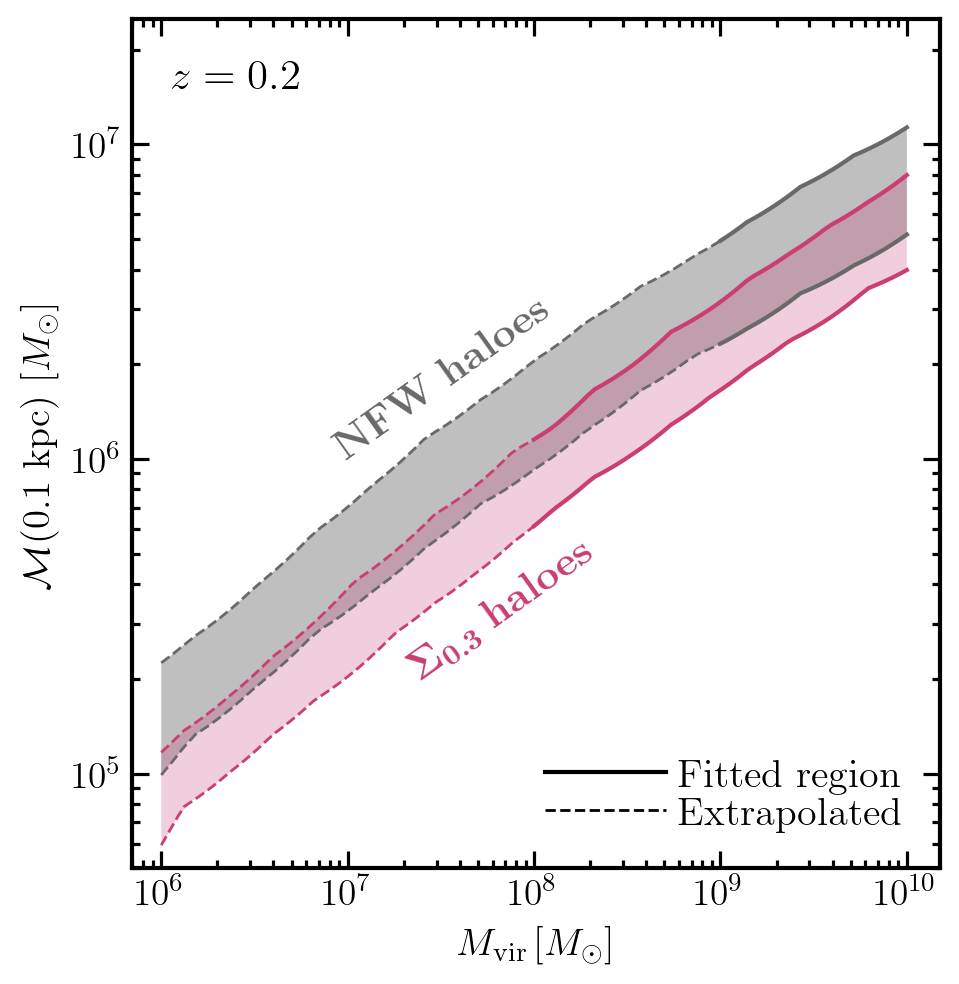

In [65]:
fig,axs=plt.subplots(figsize=(6.25/1.2,6.75/1.2),
                     nrows=1,ncols=1,
                    dpi=100)
plt.subplots_adjust(wspace=0.05, hspace=0.015)

# -----------------------------------------------------------------------------------------

axs.xaxis.set_tick_params(direction='in', which='both'); axs.yaxis.set_tick_params(direction='in', which='both')
axs.xaxis.set_ticks_position('both'); axs.yaxis.set_ticks_position('both')
axs.set_xlabel(r'$M_{\rm vir}\, [M_{\odot}]$'); axs.set_ylabel(r'$\mathcal{M}(0.1\ \mathrm{kpc})\ [M_{\odot}]$')
axs.set_xscale('log'); axs.set_yscale('log');
axs.set_xlim(7e5, 1.5e10); axs.set_ylim(5e4, 2.5e7)

# -----------------------------------------------------------------------------------------

axs.text(8e6, 1e6, r'\boldmath$\rm NFW\ haloes$', color='dimgray', rotation=35.5)
res = np.loadtxt('nfw_res.txt', delimiter=' ', dtype=np.float64)
#axs.scatter(res[:, 0], res[:, 1], s=2.5, c='dimgray')

stats_nfw = ba.get_statistics(xdata=res[:, 0], 
                              ydata=res[:, 2], 
                              nbins=15,
                              xbound=(1e6, 1e10),
                              clean_up=True)

marr = 10**np.linspace(6, 10)
marr1 = 10**np.linspace(9, 10)
marr2 = 10**np.linspace(6, 9)
intp1 = interp1d(stats_nfw['x.bins'], stats_nfw['y.3sigma.lower'], fill_value='extrapolate')
intp2 = interp1d(stats_nfw['x.bins'], stats_nfw['y.3sigma.upper'], fill_value='extrapolate')
axs.fill_between(marr, 
                 intp1(marr), 
                 intp2(marr), 
                 edgecolor='None', facecolor='k', alpha=0.25)
axs.plot(marr1, intp1(marr1), lw=1.5, color='dimgray')
axs.plot(marr1, intp2(marr1), lw=1.5, color='dimgray')
axs.plot(marr2, intp1(marr2), lw=1.0, color='dimgray', ls='--')
axs.plot(marr2, intp2(marr2), lw=1.0, color='dimgray', ls='--')

# -----------------------------------------------------------------------------------------

cmap = matplotlib.cm.get_cmap('magma')
color=cmap(0.55)

axs.text(2e7, 2e5, r'\boldmath$\rm \Sigma_{0.3}\ haloes$', color=color, rotation=35.5)
res = np.loadtxt('laz_res.txt', delimiter=' ', dtype=np.float64)
#axs.scatter(res[:, 0], res[:, 1], s=2.5, c=color)

stats_laz = ba.get_statistics(xdata=res[:, 0], 
                              ydata=res[:, 2], 
                              nbins=20,
                              xbound=(1e6, 1e10),
                              clean_up=True)

marr = 10**np.linspace(6, 10)
marr1 = 10**np.linspace(8, 10)
marr2 = 10**np.linspace(6, 8)
intp1 = interp1d(stats_laz['x.bins'], stats_laz['y.3sigma.lower'], fill_value='extrapolate')
intp2 = interp1d(stats_laz['x.bins'], stats_laz['y.3sigma.upper'], fill_value='extrapolate')
axs.fill_between(marr, 
                 intp1(marr), 
                 intp2(marr), 
                 edgecolor='None', facecolor=color, alpha=0.25)
axs.plot(marr1, intp1(marr1), lw=1.5, color=color)
axs.plot(marr1, intp2(marr1), lw=1.5, color=color)
axs.plot(marr2, intp1(marr2), lw=1.0, color=color, ls='--')
axs.plot(marr2, intp2(marr2), lw=1.0, color=color, ls='--')

# -----------------------------------------------------------------------------------------

#axs.text(5e7, 7.5e7, r'$1$:$1$', color='dimgray', rotation=45)
#axs.plot(np.linspace(1e5, 1e12), np.linspace(1e5, 1e12), color='dimgray', lw=1.0, ls=':')

from matplotlib.patches import Rectangle
empty = Rectangle((0,0), 0, 0, alpha=0.0)

sim_leg = axs.legend([empty]*7,
                [r'$z = 0.2$'],
               loc="upper left",frameon=False,ncol=1,
               fontsize=15.5,handlelength=0,handletextpad=0,labelspacing=0.05)
sim_leg.get_texts()[0].set_color('k')
axs.add_artist(sim_leg)

axs.plot(1, 1, lw=1.5, ls='-', color='k', label=r'$\rm Fitted\ region$')
axs.plot(1, 1, lw=1.0, ls='--', color='k', label=r'$\rm Extrapolated$')
axs.legend(frameon=False, loc='lower right', fontsize=14.5, handlelength=3, handletextpad=0.3, labelspacing=0.05)

plt.show()